In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [115]:
df = pd.read_csv(r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData.csv")

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450646 entries, 0 to 450645
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             450646 non-null  int64  
 1   Start                  450646 non-null  object 
 2   Stop                   450646 non-null  object 
 3   Station Name           450646 non-null  object 
 4   NO2                    445087 non-null  float64
 5   NOX as NO2             445450 non-null  float64
 6   PM2.5                  183966 non-null  float64
 7   CO                     253349 non-null  float64
 8   Black Carbon           55003 non-null   float64
 9   O3                     75291 non-null   float64
 10  National Station Code  450646 non-null  int64  
 11  Longitude              450646 non-null  float64
 12  Latitude               450646 non-null  float64
 13  Classification         450646 non-null  object 
 14  PM10                   267321 non-nu

Select Station, Drop Unwanted Columns

In [116]:
# selecting station #Stockholm Torkel Knutssongatan
df = df.loc[df['Station Name'] == "#Stockholm Torkel Knutssongatan"]

# (df['Station Name'] == "#Stockholm E4/E20 Lilla Essingen") |(df['Station Name'] == "#Stockholm Hornsgatan 108 Gata") | (df['Station Name'] == "#Stockholm Sveavägen 59 Gata") |

# rename stop column to DateTimeStamp
df = df.rename(columns={"Stop": "DateTimestamp"})

# convert columns to date
df['DateTimestamp'] = pd.to_datetime(df['DateTimestamp'])

# select columns
df = df[['DateTimestamp','Station Name','Classification', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
        
print(df['Station Name'].unique())
print()
print(df.info())
print(df.describe())

['#Stockholm Torkel Knutssongatan']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 70080 to 450645
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTimestamp   43824 non-null  datetime64[ns]
 1   Station Name    43824 non-null  object        
 2   Classification  43824 non-null  object        
 3   NO2             43420 non-null  float64       
 4   NOX as NO2      43423 non-null  float64       
 5   PM2.5           40939 non-null  float64       
 6   PM10            42113 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 2.7+ MB
None
                NO2    NOX as NO2         PM2.5          PM10
count  43420.000000  43423.000000  40939.000000  42113.000000
mean      11.363616     14.289275      4.691717     11.690390
std       10.279262     16.568498      4.064343      9.077593
min        0.300000      0.500000     -2.900000     -3.000

Removing Outliers Using Isolation Forest

In [117]:
# Generating weektype from day of week
df['Weektype'] = pd.DatetimeIndex(df['DateTimestamp']).dayofweek
# Replace weedays labels WeekDays and WeekEnds 
df['Weektype'] = df['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
df['Weektype'] = df['Weektype'].replace([5, 6], 'WeekEnd')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 70080 to 450645
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTimestamp   43824 non-null  datetime64[ns]
 1   Station Name    43824 non-null  object        
 2   Classification  43824 non-null  object        
 3   NO2             43420 non-null  float64       
 4   NOX as NO2      43423 non-null  float64       
 5   PM2.5           40939 non-null  float64       
 6   PM10            42113 non-null  float64       
 7   Weektype        43824 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 3.0+ MB
None
                NO2    NOX as NO2         PM2.5          PM10
count  43420.000000  43423.000000  40939.000000  42113.000000
mean      11.363616     14.289275      4.691717     11.690390
std       10.279262     16.568498      4.064343      9.077593
min        0.300000      0.500000     -2.90

In [118]:
# Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
df = df.assign(Hour=pd.cut(df['DateTimestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
# Replace timestamp 00:00 with Transition
df['Hour'] = df['Hour'].fillna('Transition')
df['Hour'] = df.Hour.astype(str)

# Arranging columns
df = df[['DateTimestamp','Station Name','Classification','Weektype','Hour', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]

print(df.info())
print(df.describe())
df.groupby(['Classification','Weektype','Hour']).aggregate('count').drop(['DateTimestamp'],1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 70080 to 450645
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTimestamp   43824 non-null  datetime64[ns]
 1   Station Name    43824 non-null  object        
 2   Classification  43824 non-null  object        
 3   Weektype        43824 non-null  object        
 4   Hour            43824 non-null  object        
 5   NO2             43420 non-null  float64       
 6   NOX as NO2      43423 non-null  float64       
 7   PM2.5           40939 non-null  float64       
 8   PM10            42113 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 3.3+ MB
None
                NO2    NOX as NO2         PM2.5          PM10
count  43420.000000  43423.000000  40939.000000  42113.000000
mean      11.363616     14.289275      4.691717     11.690390
std       10.279262     16.568498      4.064343      

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               5216   5161        5161   4871   
                          Peak               11736  11599       11599  10954   
                          Traffic             9128   9028        9028   8528   
                          Transition          5216   5163        5164   4873   
                 WeekEnd  Night               2088   2070        2071   1951   
                          Peak                4698   4681        4681   4390   
                          Traffic             3654   3640        3640   3417   
                          Transition          2088   2078        2079   1955   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        5010  
                          Peak        11180  
                          Traffic      8736  
                          Transition   5010  
                 WeekEnd  Night        2036  
                          Peak         4558  
                          Traffic      3545  
                          Transition   2038

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Transition"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Night"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Traffic"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Peak"


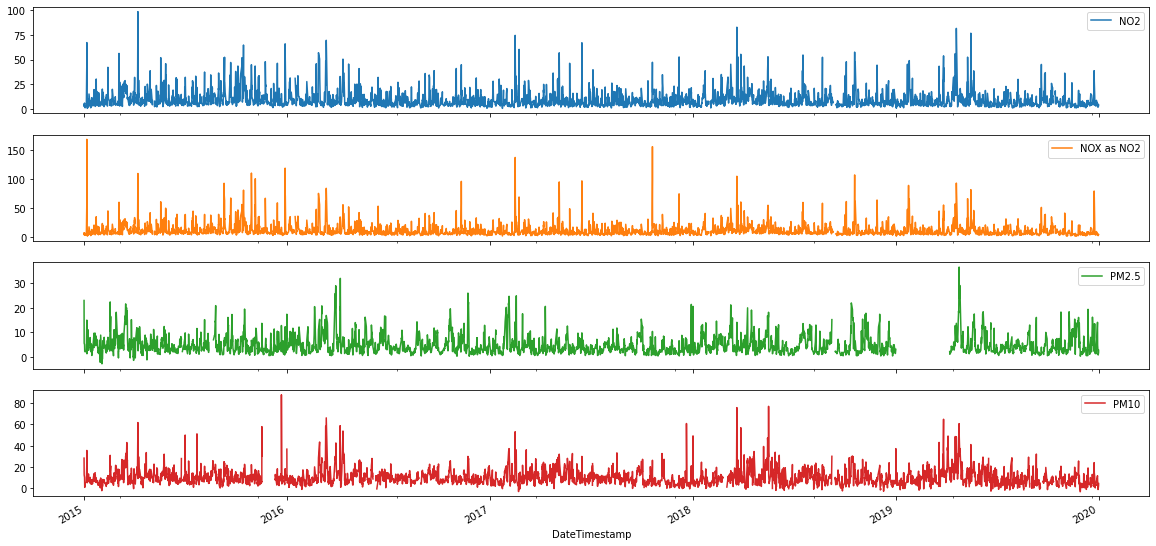

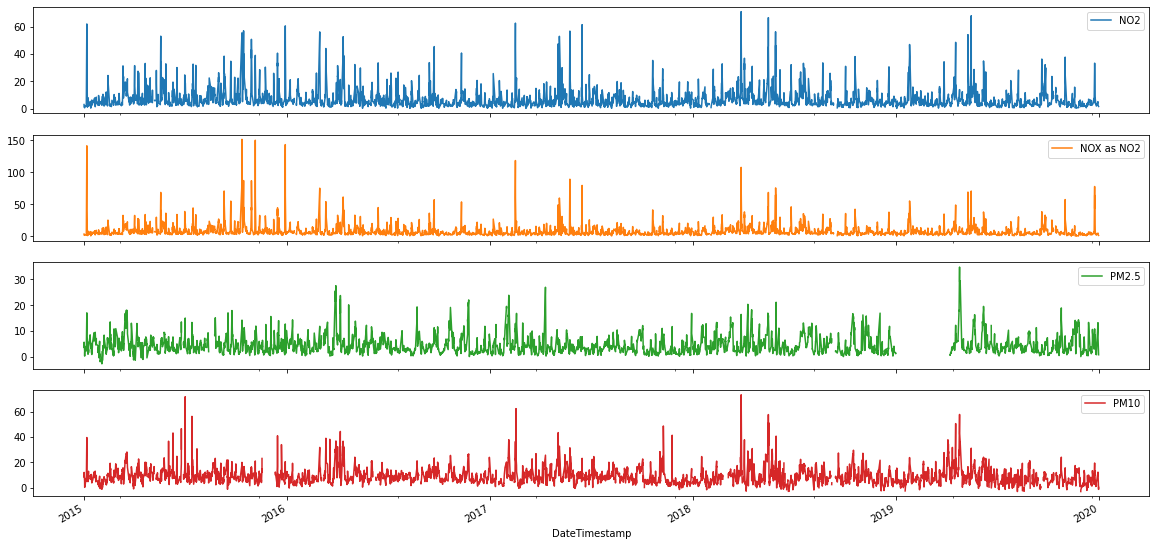

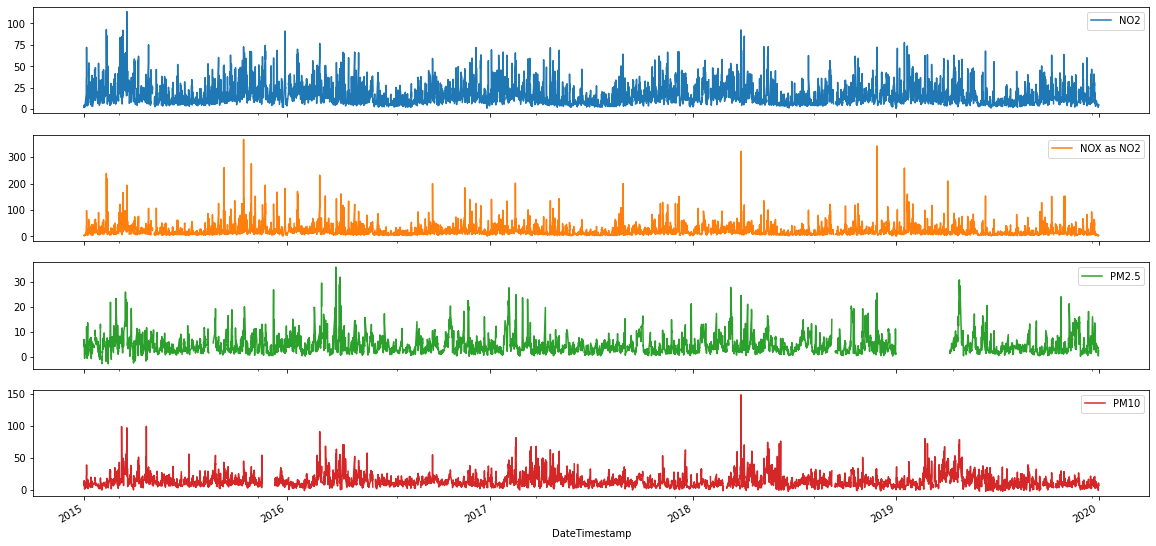

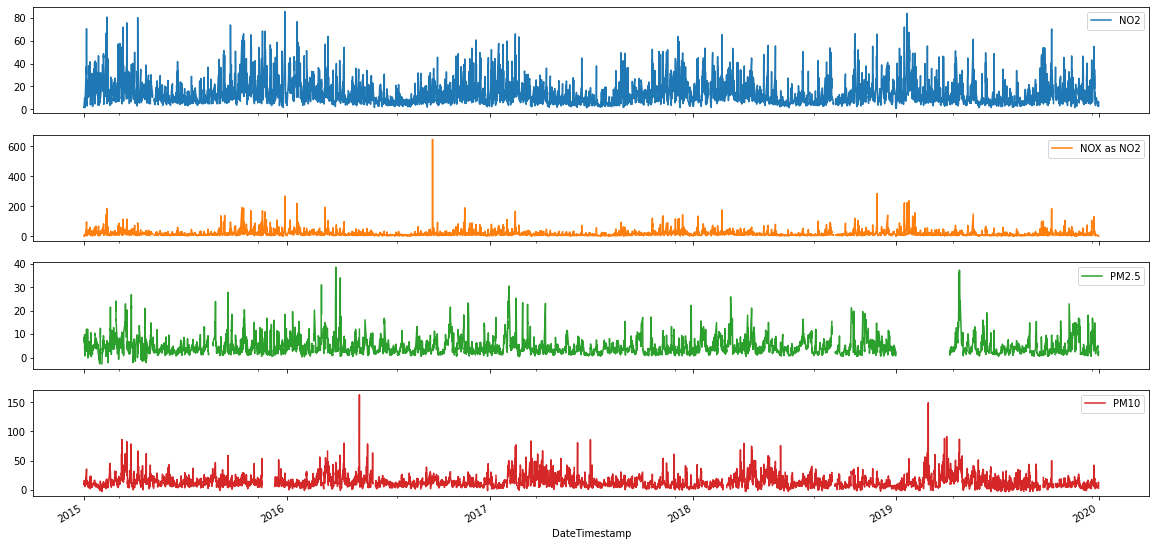

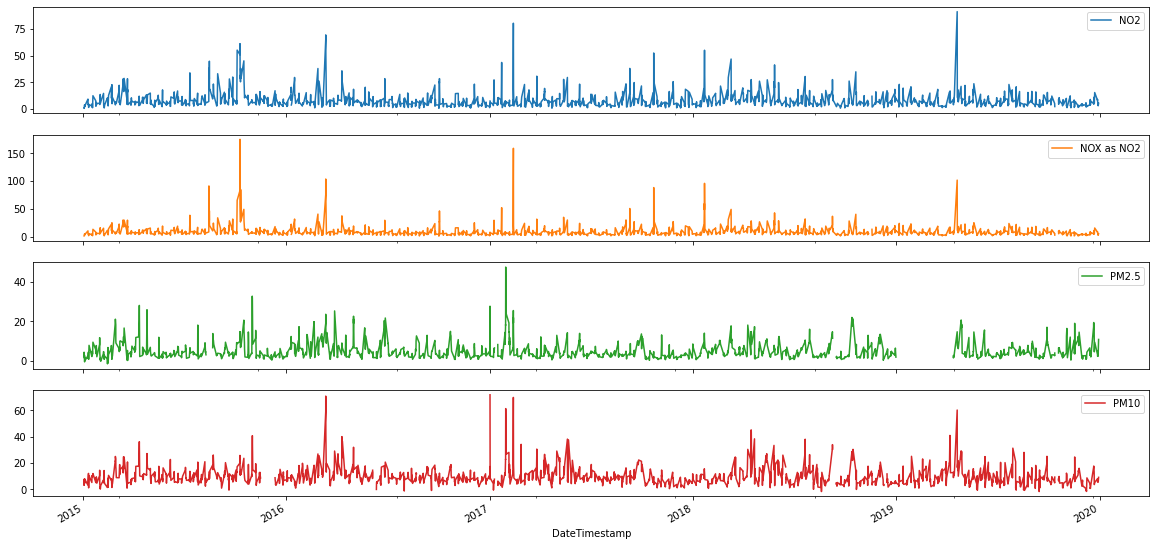

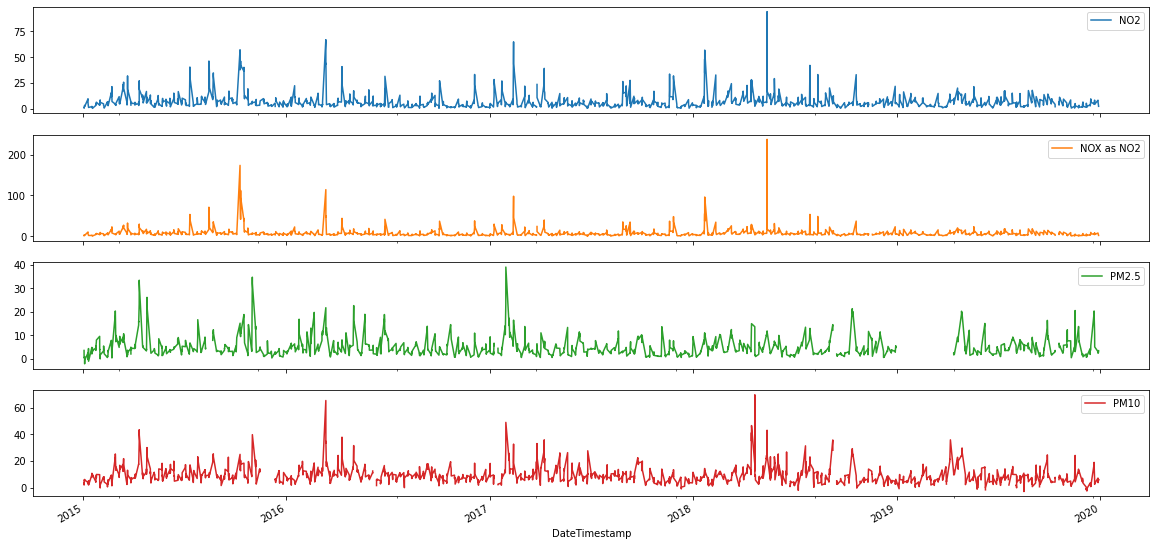

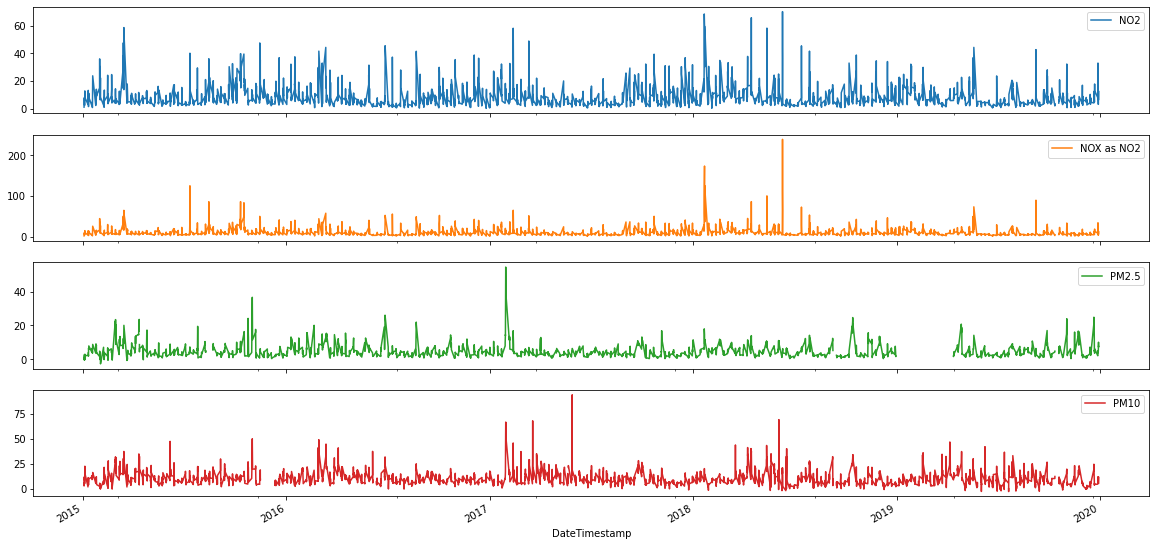

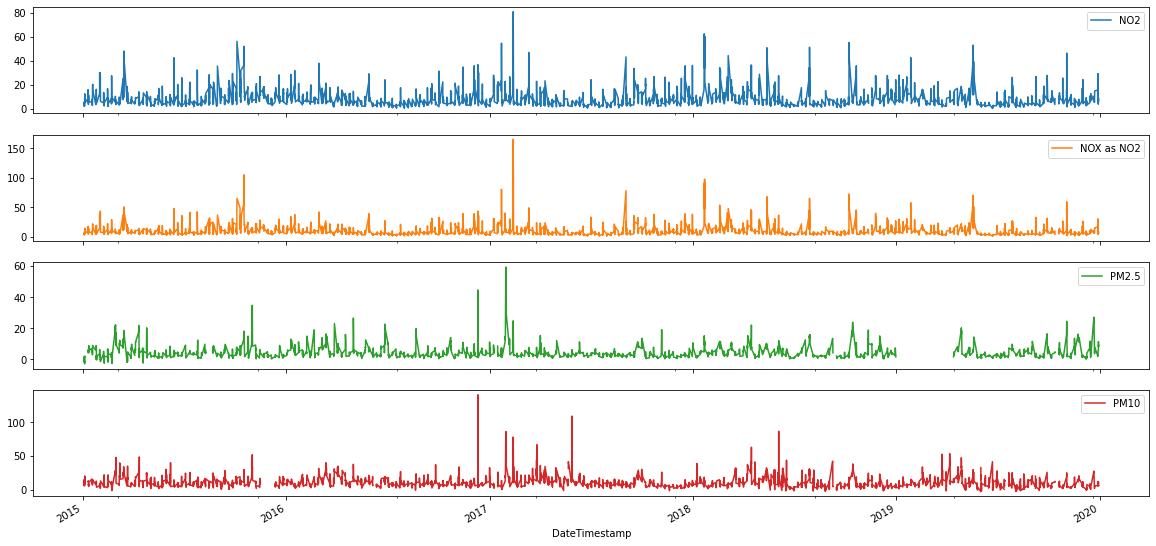

In [119]:
# Time Series before outlier removal

cfilt = list(df['Classification'].unique())
wfilt = list(df['Weektype'].unique())
hfilt = list(df['Hour'].unique())

temp = df
temp = temp.set_index("DateTimestamp")

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # generate segment data
            plot_data1 = temp.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # ploting the current segment
            plot_data1[['Station Name','Classification',
                        'Weektype','Hour','NO2', 'NOX as NO2',
                        'PM2.5', 'PM10']].plot(figsize = (20,10), subplots = True)

In [124]:
from sklearn.ensemble import IsolationForest

# remove warning
pd.set_option('mode.chained_assignment', None)

## Removing Outliers based on individual spatial classes
# replace na with zero
df_1 = df.fillna(-5)

# IsolationForest parameter
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)

cfilt = list(df_1['Classification'].unique())
wfilt = list(df_1['Weektype'].unique())
hfilt = list(df_1['Hour'].unique())

df_2 = pd.DataFrame(columns = ['DateTimestamp','Station Name','Classification',
                               'Weektype','Hour','NO2', 'NOX as NO2','PM2.5', 'PM10'])

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            print(len(df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
            temp = df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            
            # detect Outliers
            to_model_columns=temp.columns[5:9]
            # fiting data
            clf.fit(temp[to_model_columns])
            # predicting ouliers
            pred = clf.predict(temp[to_model_columns])
            # marking outliers
            temp['anomaly'] = pred
            outliers=temp.loc[temp['anomaly']==-1]
            #outlier_index=list(outliers.index)

            # number of anomalies(-1) and normal points(1)
            print(temp['anomaly'].value_counts())
            df_2 = df_2.append(temp)
            print('Appended\n')

# columns to revert back to nan            
cols = ['NO2', 'NOX as NO2','PM2.5', 'PM10']
df_2[cols] = df_2[cols].replace( -5, np.nan )
print('\n')
print('df_2 Description:')
print(df_2.info())
print(df_2.describe())

# selecting non-anomaly 
df_3 = df_2[df_2['anomaly'] == 1]
df_3 = df_3.drop(['anomaly'],axis = 1)
print('\n')
print('df_3 Description:')
print(df_3.info())
print(df_3.describe())

# saving non anomaly data
print("Saving File")
savePath = r"G:\Uppsala Docs\period5&6\ProcessedData"
df_3.to_csv(savePath+"\\"+'2015-2019_SensorData_SelectedFourStation.csv')      

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
5216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    4563
-1     653
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
5216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    4550
-1     666
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
9128


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    7797
-1    1331
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
11736


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    10189
-1     1547
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Transition"
2088


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    1836
-1     252
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Night"
2088


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    1855
-1     233
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Traffic"
3654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


 1    3166
-1     488
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Peak"
4698


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


 1    4113
-1     585
Name: anomaly, dtype: int64
Appended



df_2 Description:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 70080 to 450595
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTimestamp   43824 non-null  datetime64[ns]
 1   Station Name    43824 non-null  object        
 2   Classification  43824 non-null  object        
 3   Weektype        43824 non-null  object        
 4   Hour            43824 non-null  object        
 5   NO2             43420 non-null  float64       
 6   NOX as NO2      43423 non-null  float64       
 7   PM2.5           40939 non-null  float64       
 8   PM10            42113 non-null  float64       
 9   anomaly         43824 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 3.7+ MB
None
                NO2    NOX as NO2         PM2.5          PM10       anomaly
count  43420.000000  43423.000

In [125]:
# distribution before outlier detection
df.groupby(['Classification',
            'Weektype',
            'Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.3    4.5   70.9        0.5    5.3   
                          Peak        0.9   10.6   85.2        1.6   13.1   
                          Traffic     0.7   13.0  113.5        1.3   15.1   
                          Transition  0.4    6.4   98.6        0.9    7.2   
                 WeekEnd  Night       0.4    4.8   94.2        0.6    5.6   
                          Peak        0.5    6.1   81.1        1.4    7.5   
                          Traffic     0.3    5.9   70.1        1.0    7.1   
                          Transition  0.3    5.9   91.3        0.9    6.8   

                                            PM2.5              PM10         \
                                        max   min median   max  min median   
Classification   Weektype Hour                                               
Urban Background WeekDay  Night       151.7  -2.7    3.5  34.7 -3.0    7.7   
                          Peak        647.0  -2.7    3.5  38.6 -2.9   11.0   
                          Traffic     367.0  -2.8    3.6  36.0 -3.0   10.9   
                          Transition  168.1  -2.9    3.6  36.5 -2.9    8.7   
                 WeekEnd  Night       237.4  -2.2    3.7  39.0 -3.0    7.9   
                          Peak        165.2  -2.8    3.3  59.3 -2.8    8.9   
                          Traffic     239.5  -2.8    3.5  54.5 -3.0    8.8   
                          Transition  175.1  -1.6    3.8  47.6 -1.8    8.5   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        73.3  
                          Peak        162.6  
                          Traffic     148.0  
                          Transition   87.7  
                 WeekEnd  Night        69.6  
                          Peak        140.4  
                          Traffic      94.0  
                          Transition   71.8

In [126]:
# distribution after outlier detection
df_3.groupby(['Classification',
              'Weektype',
              'Hour']).aggregate(['min', np.median, 'max'])

NO2              NOX as NO2         \
                                      min median   max        min median   
Classification   Weektype Hour                                             
Urban Background WeekDay  Night       0.3    4.2  23.0        0.8    5.0   
                          Peak        1.5    9.9  39.6        2.3   12.2   
                          Traffic     0.9   12.0  45.5        1.7   14.0   
                          Transition  0.4    5.9  27.4        0.9    6.8   
                 WeekEnd  Night       0.4    4.4  20.3        0.6    5.2   
                          Peak        0.6    5.7  24.7        1.5    7.0   
                          Traffic     0.3    5.4  24.9        1.0    6.6   
                          Transition  0.3    5.4  21.7        0.9    6.3   

                                           PM2.5              PM10         \
                                       max   min median   max  min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       24.4  -2.7    3.2  14.9 -3.0   7.10   
                          Peak        55.1  -2.7    3.2  16.2 -2.9  10.30   
                          Traffic     65.7  -2.8    3.4  16.7 -3.0  10.10   
                          Transition  31.1  -2.9    3.3  16.5 -2.9   8.00   
                 WeekEnd  Night       22.8  -2.2    3.5  19.4 -3.0   7.50   
                          Peak        30.5  -2.8    3.1  18.0 -2.8   8.40   
                          Traffic     29.0  -2.8    3.2  16.8 -3.0   8.35   
                          Transition  23.3  -1.6    3.5  17.7 -1.8   8.00   

                                            
                                       max  
Classification   Weektype Hour              
Urban Background WeekDay  Night       24.9  
                          Peak        45.5  
                          Traffic     40.3  
                          Transition  30.4  
                 WeekEnd  Night       26.7  
                          Peak        38.8  
                          Traffic     33.6  
                          Transition  28.0

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Transition"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Night"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Traffic"
Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Peak"


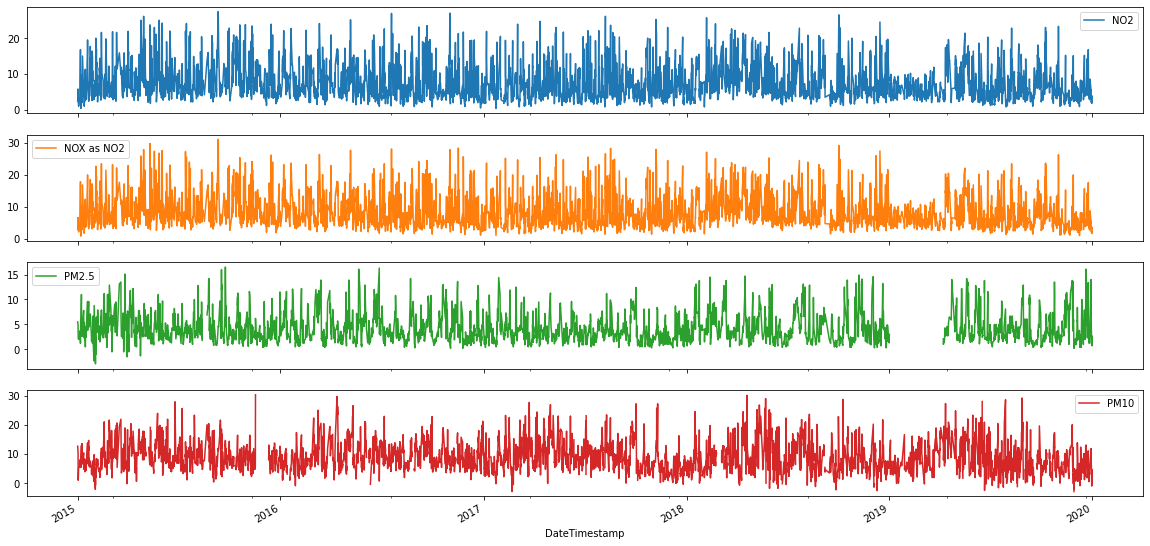

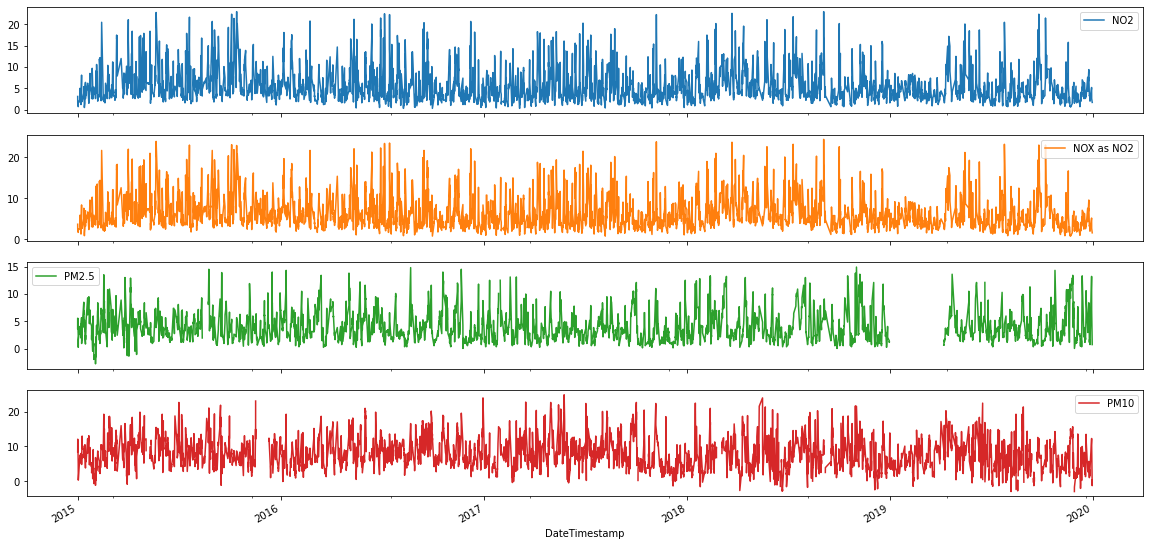

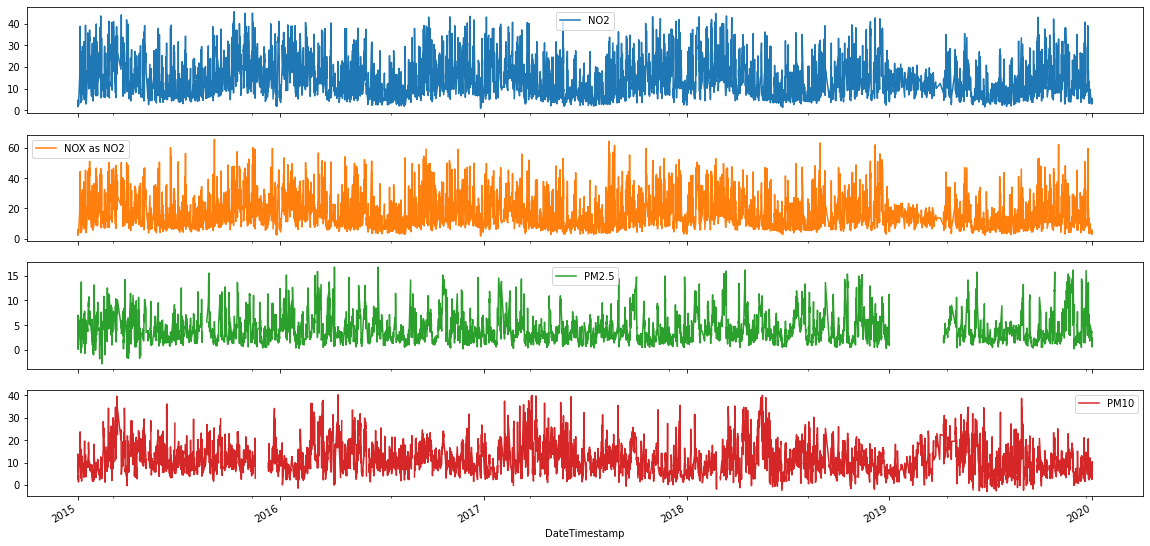

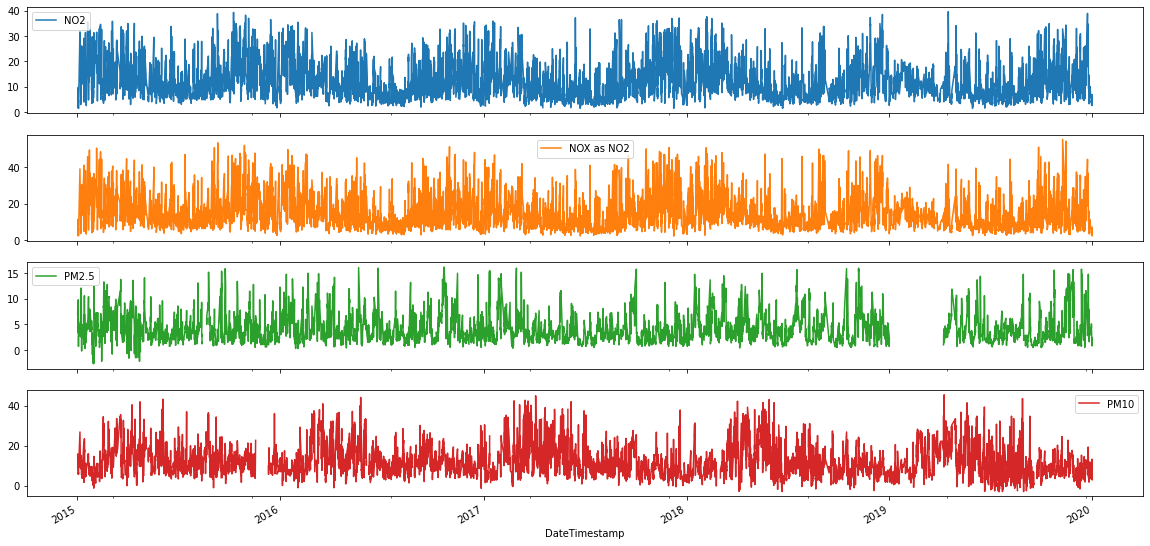

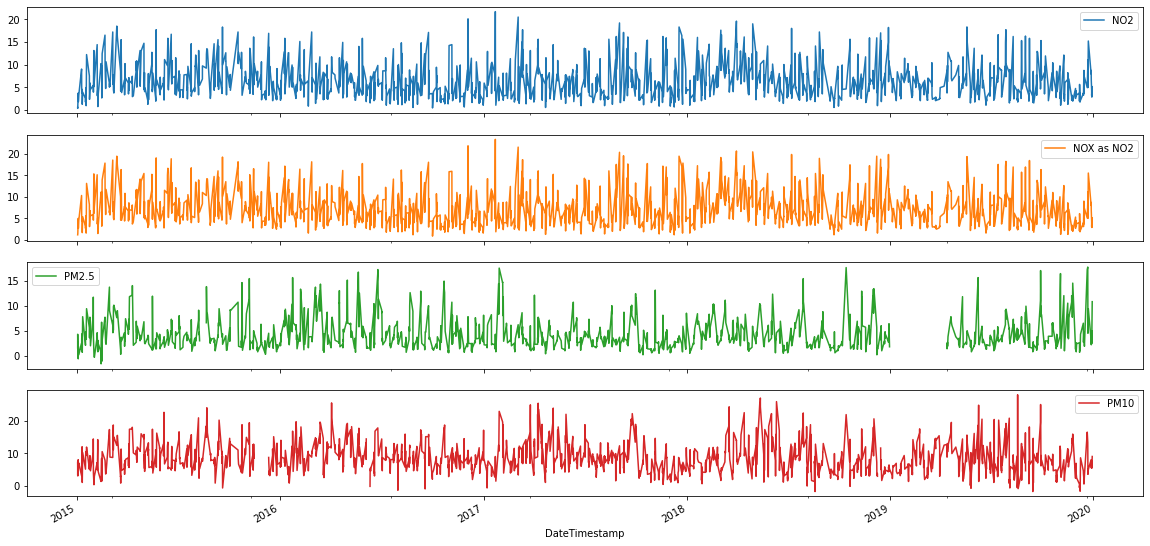

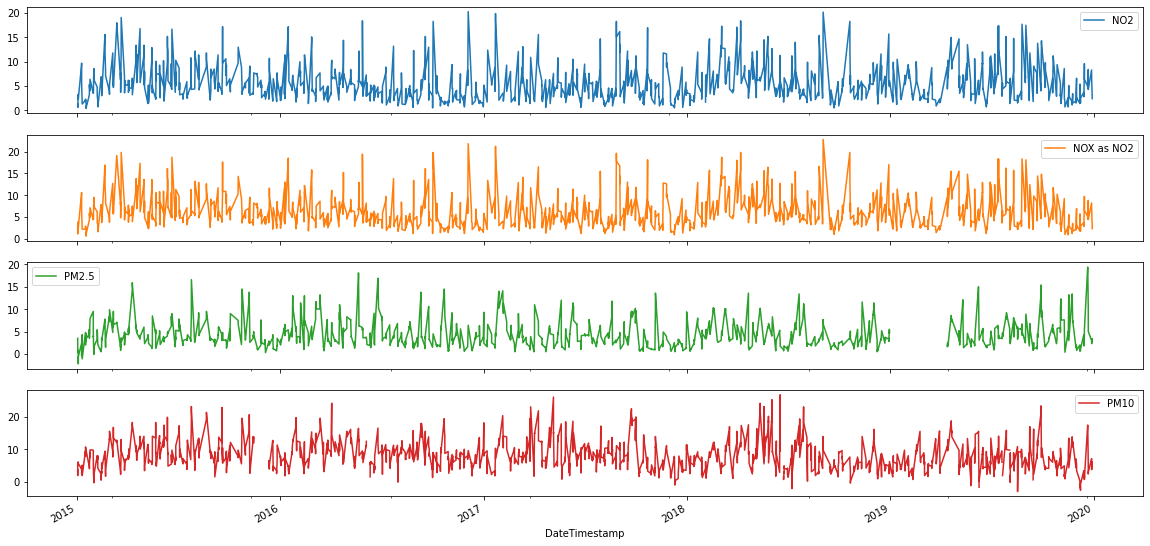

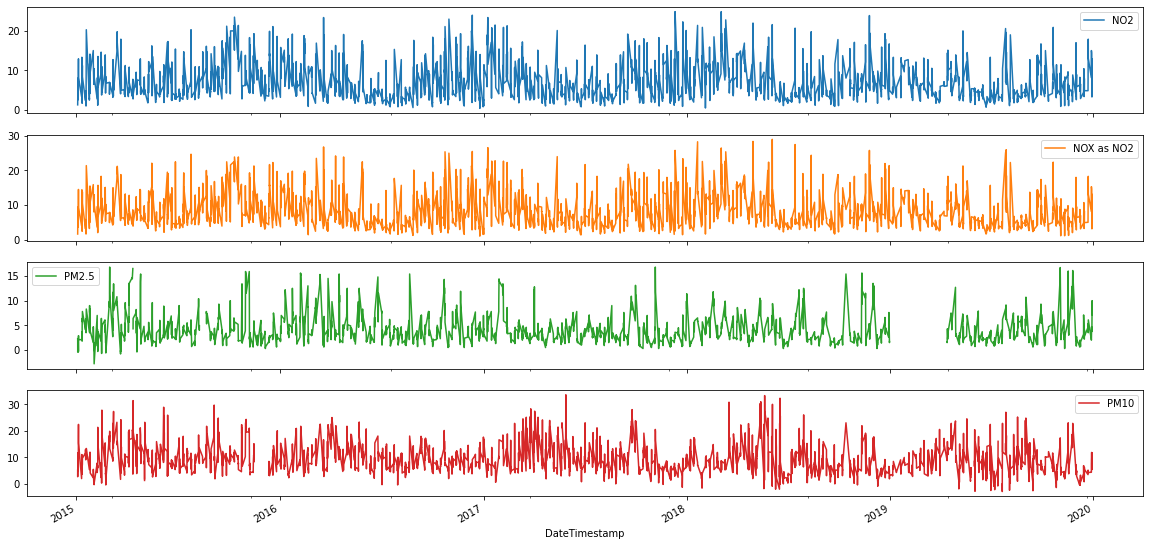

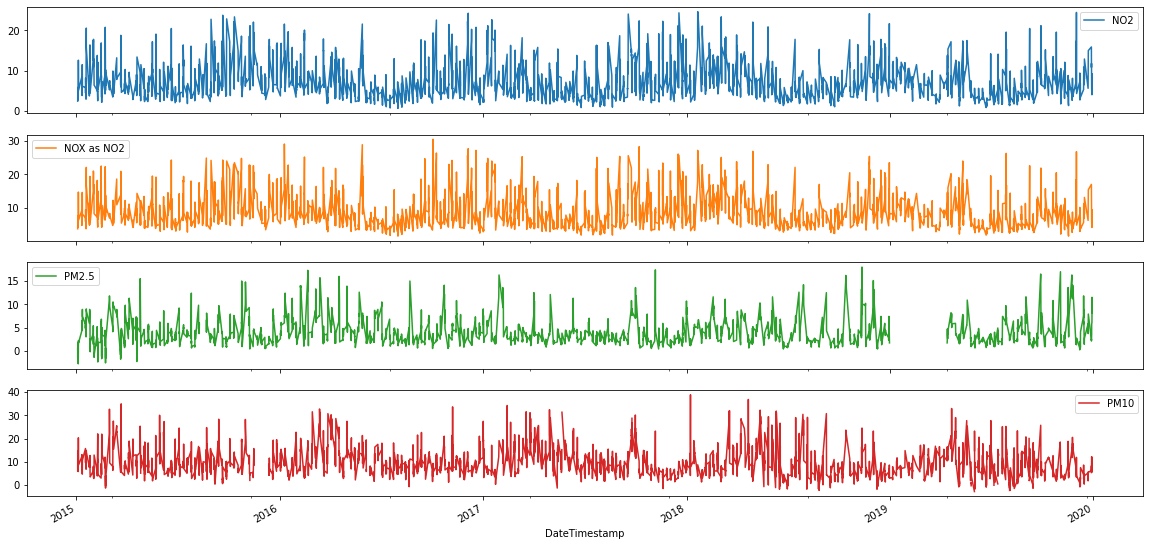

In [127]:
# Time Series before outlier removal

cfilt = list(df['Classification'].unique())
wfilt = list(df['Weektype'].unique())
hfilt = list(df['Hour'].unique())

temp = df_3
temp = temp.set_index("DateTimestamp")

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # generate segment data
            plot_data1 = temp.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # ploting the current segment
            plot_data1[['Station Name','Classification',
                        'Weektype','Hour','NO2', 'NOX as NO2',
                        'PM2.5', 'PM10']].plot(figsize = (20,10), subplots = True)

In [174]:
## onehot encoding catergories column
# Get dummies
df1 = pd.get_dummies(df[['DateTimestamp','Classification','Weektype','Hour',
                            'NO2', 'NOX as NO2','PM2.5', 'PM10']])
print(df1.info())
print(df1.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 70080 to 450645
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DateTimestamp                    43824 non-null  datetime64[ns]
 1   NO2                              43420 non-null  float64       
 2   NOX as NO2                       43423 non-null  float64       
 3   PM2.5                            40939 non-null  float64       
 4   PM10                             42113 non-null  float64       
 5   Classification_Urban Background  43824 non-null  uint8         
 6   Weektype_WeekDay                 43824 non-null  uint8         
 7   Weektype_WeekEnd                 43824 non-null  uint8         
 8   Hour_Night                       43824 non-null  uint8         
 9   Hour_Peak                        43824 non-null  uint8         
 10  Hour_Traffic                     43824 non-null  uint

In [175]:
# No of zeros, negative and null rows
print('\nNo of Zeros Entries:\n',(df1.iloc[:,1:11] == 0).astype(int).sum(axis=0))
print('\nNo of negative Entries:\n',(df1.iloc[:,1:11] < 0).astype(int).sum(axis=0))
print('\nNo of null Entries:\n',(df1.iloc[:,1:11].isnull()).astype(int).sum(axis=0))
# # drop negative rows
# df_4 = df_4[~(df_4.iloc[:,1:16] < 0).any(1)]
# # drop nan rows
# df_4 = df_4[~(df_4.iloc[:,1:16].isnull()).any(1)]
# print(df_4.info())
# print(df_4.describe())
# print(df_4.columns)


No of Zeros Entries:
 NO2                                    0
NOX as NO2                             0
PM2.5                                  7
PM10                                  40
Classification_Urban Background        0
Weektype_WeekDay                   12528
Weektype_WeekEnd                   31296
Hour_Night                         36520
Hour_Peak                          27390
Hour_Traffic                       31042
dtype: int64

No of negative Entries:
 NO2                                  0
NOX as NO2                           0
PM2.5                              149
PM10                               410
Classification_Urban Background      0
Weektype_WeekDay                     0
Weektype_WeekEnd                     0
Hour_Night                           0
Hour_Peak                            0
Hour_Traffic                         0
dtype: int64

No of null Entries:
 NO2                                 404
NOX as NO2                          401
PM2.5                  

In [185]:
# Generating Year
df_4['Year'] = df_4['DateTimestamp'].dt.year

# dropping 2020 data
df_4 = df_4[df_4['Year'] != 2020]

# defining the length of the train and test 
train_len = df_4.loc[df_4['Year'].isin([2015,2016,2017])].shape[0]
print('Train:',df_4.loc[df_4['Year'].isin([2015,2016,2017])].shape[0])
print('Test: ',df_4.loc[df_4['Year'].isin([2018,2019])].shape[0])

Train: 23271
Test:  14797


In [186]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Modyfying data for training LSTM 

# selecting PM10 column
data_set  = df_4.iloc[:,1:11].values
data_set  = data_set.reshape(-1,10)
print("Data Set:\n",data_set[0])
print("Shape:\n",data_set.shape)
print()

# Normalisation of Data
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(data_set)
print("Normalised Data Set:\n",data_set_scaled[0])
print()

# replace nan with -5
data_set_scaled[np.isnan(data_set_scaled)] = -0.00001

# Generating Features and predictions
X = data_set_scaled[0:len(data_set_scaled)-1,:]
y = data_set_scaled[1:len(data_set_scaled),3] # PM10 index 3

print("X:\n",X[0:3])
print("Y:\n",y[0:3])
print()
print("X Shape:\n",X.shape)
print("Y Shape:\n",y.shape)

Data Set:
 [ 2.4  3.1  5.5 12.7  1.   1.   0.   0.   0.   0. ]
Shape:
 (38068, 10)

Normalised Data Set:
 [0.04646018 0.03840246 0.37668161 0.32371134 0.         1.
 0.         0.         0.         0.        ]

X:
 [[0.04646018 0.03840246 0.37668161 0.32371134 0.         1.
  0.         0.         0.         0.        ]
 [0.12168142 0.093702   0.34977578 0.27628866 0.         1.
  0.         0.         0.         0.        ]
 [0.05752212 0.04608295 0.32735426 0.24329897 0.         1.
  0.         0.         0.         0.        ]]
Y:
 [0.27628866 0.24329897 0.22061856]

X Shape:
 (38067, 10)
Y Shape:
 (38067,)


In [187]:
# generate object to inverse transform the predicted data
print(data_set_scaled[0:len(data_set_scaled)-1,1][0])
print(data_set[0:len(data_set)-1,1][0])
i_sc = MinMaxScaler(feature_range = (0, 1))
print(i_sc.fit_transform(data_set[:,1].reshape(-1, 1))[0])

0.03840245775729646
3.1
[0.03840246]


In [188]:
## splitting data into test and train
X_train, X_test = X[0:train_len], X[train_len+1:len(X)]
y_train, y_test = y[0:train_len], y[train_len+1:len(X)]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_shape:\n",X_train.shape)
print("y_train_shape:\n",y_train.shape)
print("X_test_shape:\n",X_test.shape)
print("y_test_shape:\n",y_test.shape)

X_train_shape:
 (23271, 1, 10)
y_train_shape:
 (23271,)
X_test_shape:
 (14795, 1, 10)
y_test_shape:
 (14795,)


In [189]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Masking


## LSTM Architecture
# input layer
model = Sequential()
# Masking Layer
model.add(Masking(mask_value=-0.00001,input_shape=(X_train.shape[1], X_train.shape[2])))
# 1
model.add(LSTM(units=5,return_sequences = False))
# output layer
model.add(Dense(units=1))
# model architecture
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 1, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 326
Trainable params: 326
Non-trainable params: 0
_________________________________________________________________


In [190]:
# Compile LSTM Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Train the model on the data
history = model.fit(X_train, y_train, epochs = 10,batch_size = 32, validation_data= (X_test, y_test))

Epoch 1/10
728/728 [==============================] - 22s 30ms/step - loss: 0.0182 - val_loss: 0.0121
Epoch 2/10
728/728 [==============================] - 19s 26ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 3/10
728/728 [==============================] - 18s 25ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 4/10
728/728 [==============================] - 19s 26ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 5/10
728/728 [==============================] - 19s 26ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 6/10
728/728 [==============================] - 22s 30ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 7/10
728/728 [==============================] - 19s 26ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 8/10
728/728 [==============================] - 20s 27ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 9/10
728/728 [==============================] - 20s 28ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 10/10
728/728 [==============================] - 19s 26ms/step - loss: 0.008

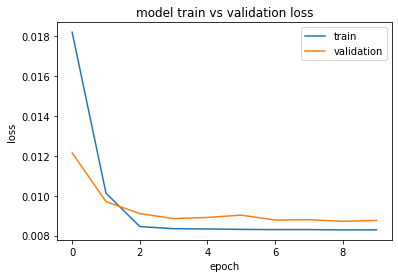

In [191]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [192]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# predicting PM10
predicted_y = model.predict(X_test)

# De-normalising predicted y data
predicted_y = i_sc.inverse_transform(predicted_y)
# De-normalising actual y data
y_actual = i_sc.inverse_transform(y_test.reshape(-1,1))

# calculating RMSE
rmse = sqrt(mean_squared_error(y_actual.reshape(-1,1), predicted_y))
rmse

6.093180396039317

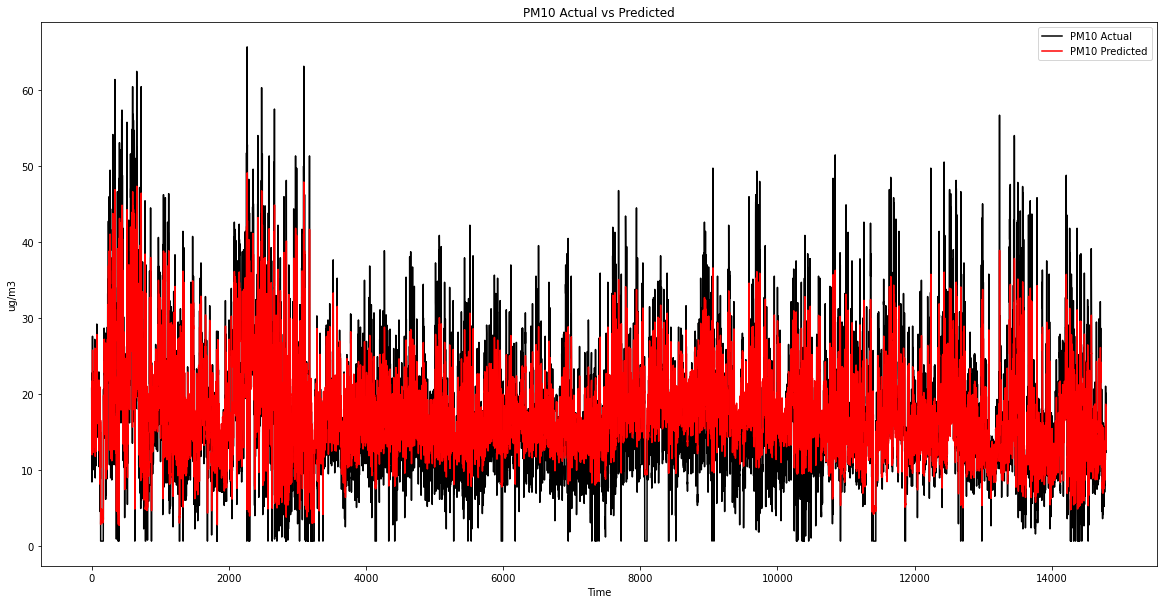

In [193]:
plt.figure(figsize=(20,10))
plt.plot(y_actual, color = 'black', label = 'PM10 Actual')
plt.plot(predicted_y, color = 'red', label = 'PM10 Predicted')
plt.title('PM10 Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('ug/m3')
plt.legend()
plt.show()